**Objective**: Quantify how the reservoir states change under pertubation.

- pertubate directly after the burn in time

In [51]:
import os
os.chdir(os.path.join(os.getcwd(), "../code"))
import numpy as np
from parameters import Params
import matplotlib.pyplot as plt
from agent import Reservoir
from environment import Environment
from tqdm.notebook import tqdm
from config import DATA_PATH
from pathlib import Path

time_steps = 300
repeats = 50

params = Params.from_json('parameters.json')
params.save = False
params.iterations = 1
data = []
environment = Environment(params)
folder = 'dynamical_stability'
path = Path(DATA_PATH) / folder
path.mkdir(parents=True, exist_ok=True)

  0%|          | 0/9 [00:00<?, ?it/s]

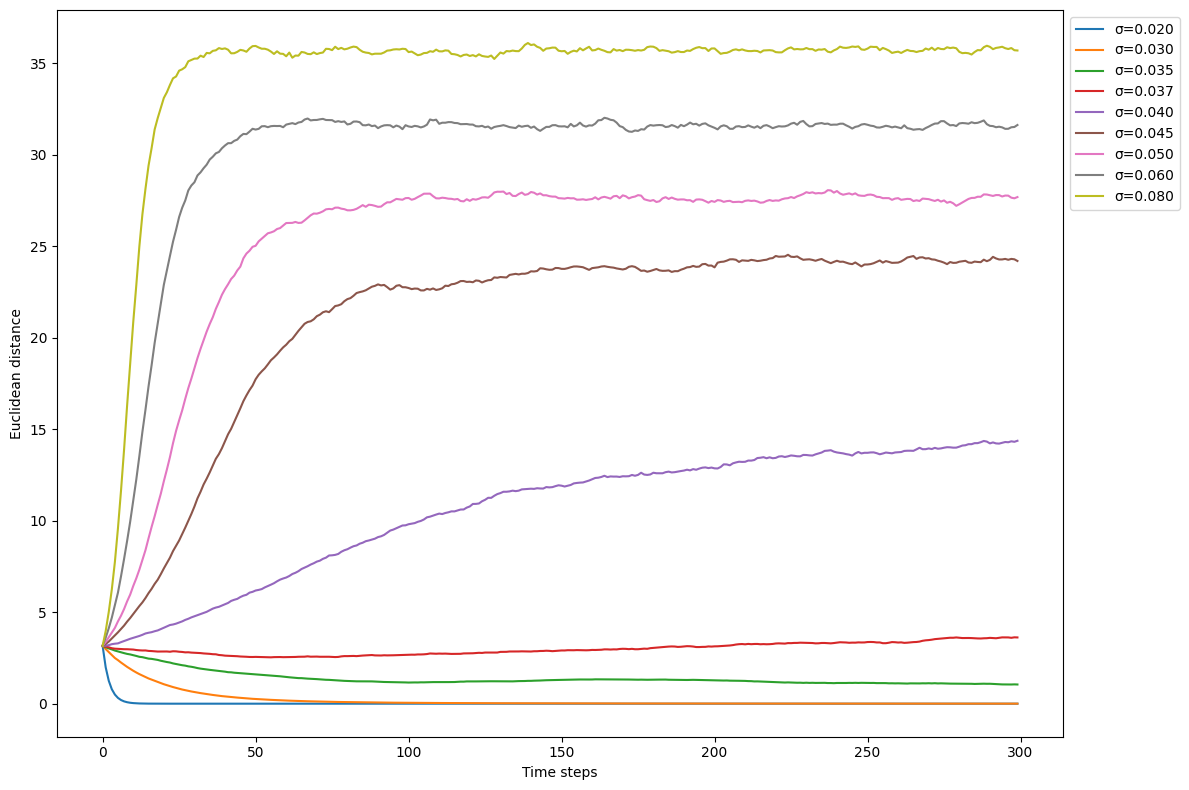

In [52]:
sigma_range = [0.02, 0.03, 0.035, 0.037, 0.04, 0.045, 0.05, 0.06, 0.08]
perturbation_strength=0.1

results = []

for sigma in tqdm(sigma_range):
    averaged_distances = []
    for repeat in range(repeats):
        distances = []
        # original reservoir
        baseline_reservoir = Reservoir(time_steps=time_steps, standard_deviation=sigma)
        # perturbed reservoir with same weight matrix as original one
        perturbed_reservoir = Reservoir(time_steps=time_steps, standard_deviation=sigma)
        perturbed_reservoir.weight_matrix = baseline_reservoir.weight_matrix.copy()
        perturbed_initial_state = baseline_reservoir.burn_in_state_matrix[-1] + np.random.normal(0, perturbation_strength, baseline_reservoir.num_neurons)
        perturbed_reservoir.neuron_state_time_matrix[0] = perturbed_initial_state
        for t in range(1, time_steps):
            perturbed_reservoir.neuron_state_time_matrix[t] = np.tanh(np.dot(perturbed_reservoir.weight_matrix, perturbed_reservoir.neuron_state_time_matrix[t - 1]))
        # calculate Euclidean distance over time
        for t in range(time_steps):
            dist = np.linalg.norm(baseline_reservoir.neuron_state_time_matrix[t] - perturbed_reservoir.neuron_state_time_matrix[t])
            distances.append(dist)
        averaged_distances.append(distances)
    averaged_distances = np.mean(averaged_distances, axis=0)
    results.append(np.array(averaged_distances))

plt.figure(figsize=(12,8))
for i, sigma in enumerate(sigma_range):
    plt.plot(results[i], label=f'σ={sigma:.3f}')
plt.xlabel('Time steps')
plt.ylabel('Euclidean distance')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.savefig(path / 'dynamical_stability.svg', format='svg', bbox_inches='tight')